<a href="https://colab.research.google.com/github/alitheonly/PlantSeedling-/blob/main/0_5_Drop_RMSProp_All_B32_0214.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c plant-seedlings-classification
!unzip plant-seedlings-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: test/ad12382d4.png      
  inflating: test/adb7a032c.png      
  inflating: test/ae90f2827.png      
  inflating: test/aecfaed64.png      
  inflating: test/aee6fa3df.png      
  inflating: test/af45e222a.png      
  inflating: test/afa446484.png      
  inflating: test/afcf6abd5.png      
  inflating: test/b026bf8ca.png      
  inflating: test/b03397525.png      
  inflating: test/b0acaff4a.png      
  inflating: test/b130a0632.png      
  inflating: test/b145ba9d4.png      
  inflating: test/b1cd2a91e.png      
  inflating: test/b215531dd.png      
  inflating: test/b2706e2b3.png      
  inflating: test/b29339405.png      
  inflating: test/b30ab4659.png      
  inflating: test/b31292706.png      
  inflating: test/b341d0aab.png      
  inflating: test/b39c71707.png      
  inflating: test/b3d6fdb80.png      
  inflating: test/b3e08b037.png      
  inflating: test/b47691c08.png      
  inflating: test/b4c3df835.png      

In [ ]:

# Import necessary libraries

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam
import tensorflow as tf
import cv2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import random
from glob import glob
import imageio
from keras.optimizers import RMSprop

In [ ]:
!ls ../content/train

 Black-grass	    'Common wheat'	'Scentless Mayweed'
 Charlock	    'Fat Hen'		'Shepherds Purse'
 Cleavers	    'Loose Silky-bent'	'Small-flowered Cranesbill'
'Common Chickweed'   Maize		'Sugar beet'


In [ ]:
data_path = '/content/'
train_dir = os.path.join(data_path,'train')
test_dir = os.path.join(data_path, 'test')

In [ ]:
images_path= '/content/train/*/*.png'
images = glob(images_path)

img_size = 224
train_images = []
train_labels = []
for i in images:
    train_images.append(cv2.resize(cv2.imread(i), (img_size, img_size))) 
    train_labels.append(i.split('/')[-2])
train_X = np.asarray(train_images)
train_Y = pd.DataFrame(train_labels)

In [ ]:
train_X

array([[[[ 54,  65,  81],
         [ 51,  60,  77],
         [ 38,  50,  71],
         ...,
         [ 70,  93, 106],
         [ 66,  87, 105],
         [ 60,  82, 105]],

        [[ 59,  67,  81],
         [ 54,  63,  78],
         [ 52,  60,  77],
         ...,
         [ 75,  91, 103],
         [ 78,  95, 108],
         [ 71,  87, 105]],

        [[ 76,  82,  98],
         [ 73,  80,  96],
         [ 55,  64,  82],
         ...,
         [ 75,  94, 107],
         [ 75,  95, 106],
         [ 80, 100, 111]],

        ...,

        [[ 61,  64,  72],
         [ 64,  65,  73],
         [ 68,  71,  79],
         ...,
         [ 71,  83, 101],
         [ 67,  81,  95],
         [ 68,  86, 102]],

        [[ 50,  51,  54],
         [ 52,  50,  54],
         [ 63,  60,  64],
         ...,
         [ 68,  80,  97],
         [ 81,  96, 106],
         [ 69,  87, 103]],

        [[ 51,  50,  53],
         [ 51,  49,  50],
         [ 62,  61,  64],
         ...,
         [ 68,  86,  99],
        

In [ ]:
train_Y

,0
0,Sugar beet
1,Sugar beet
2,Sugar beet
3,Sugar beet
4,Sugar beet
...,...
4745,Small-flowered Cranesbill
4746,Small-flowered Cranesbill
4747,Small-flowered Cranesbill
4748,Small-flowered Cranesbill


In [ ]:
train_Y.rename(columns={0:'species'},inplace=True)
_, train_count = np.unique(train_Y,return_counts=True)
df = pd.DataFrame(data = train_count)
a = train_Y['species'].unique()
a = a.tolist()
a.sort()
df['Index'] = a
df.columns = ['Train','Name']
df

,Train,Name
0,263,Black-grass
1,390,Charlock
2,287,Cleavers
3,611,Common Chickweed
4,221,Common wheat
5,475,Fat Hen
6,654,Loose Silky-bent
7,221,Maize
8,516,Scentless Mayweed
9,231,Shepherds Purse


In [ ]:
from sklearn.preprocessing import LabelBinarizer
y = LabelBinarizer().fit_transform(train_Y.species)
train_label = np.array(y,dtype=np.float32)
train_label

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(train_X, train_label,test_size=0.3,random_state=7)
print((X_train.shape,X_test.shape))

((3325, 224, 224, 3), (1425, 224, 224, 3))



**Image** Normalization




In [ ]:
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255 

## Image Data Generator

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        rotation_range=180,  
        zoom_range = 0.1,
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=True  
    )  
datagen.fit(train_X)

VGG Model

In [ ]:

from keras.applications.vgg16 import VGG16

# Instantiate a VGG16 model with pre-trained weights

base_model= VGG16(weights='imagenet',input_shape=(224, 224, 3),include_top=False)
base_model.trainable = False



58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)


# Add a logistic layer
predictions = Dense(12, activation='softmax')(x)
x = Dropout(0.5)(x)


# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)


In [ ]:
#Saving the best model using model checkpoint callback
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = tf.keras.callbacks.ModelCheckpoint('Split Sklearn Train/Valid VGG16.h5', #where to save the model
                                                    save_best_only=True, 
                                                    monitor='val_accuracy', 
                                                    mode='max', 
                                                    verbose = 1)

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
model.save('VGG16_other_0129.h5')

In [ ]:
print(os.path.getsize("VGG16_other_0129.h5")/1048576, "MB")

58.25103759765625 MB


In [ ]:


# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:

# Train the model

history=model.fit(X_train, y_train , epochs=25, batch_size=32, validation_data=(X_test, y_test))#,callbacks = [early_stopping,checkpoint])

Epoch 1/25
104/104 [==============================] - 149s 1s/step - loss: 2.2043 - accuracy: 0.2493 - val_loss: 2.0168 - val_accuracy: 0.3067
Epoch 2/25
104/104 [==============================] - 146s 1s/step - loss: 1.8712 - accuracy: 0.3705 - val_loss: 1.7141 - val_accuracy: 0.3902
Epoch 3/25
104/104 [==============================] - 147s 1s/step - loss: 1.6966 - accuracy: 0.4226 - val_loss: 1.6113 - val_accuracy: 0.4091
Epoch 4/25
104/104 [==============================] - 146s 1s/step - loss: 1.5866 - accuracy: 0.4532 - val_loss: 1.5192 - val_accuracy: 0.4870
Epoch 5/25
104/104 [==============================] - 146s 1s/step - loss: 1.4846 - accuracy: 0.4806 - val_loss: 1.3990 - val_accuracy: 0.4919
Epoch 6/25
104/104 [==============================] - 148s 1s/step - loss: 1.4149 - accuracy: 0.5068 - val_loss: 1.3307 - val_accuracy: 0.5509
Epoch 7/25
104/104 [==============================] - 148s 1s/step - loss: 1.3405 - accuracy: 0.5257 - val_loss: 1.3500 - val_accuracy: 0.5242

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
model.save('VGG16_other_0129.h5')

In [ ]:
print(os.path.getsize("VGG16_other_0129.h5")/1048576, "MB")

60.31834411621094 MB


In [ ]:
#from google.colab import files
# model.save('Split Sklearn Train/Valid VGG16.h5')
#files.download('Split Sklearn Train/Valid VGG16.h5')

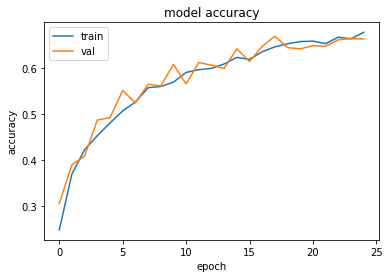

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

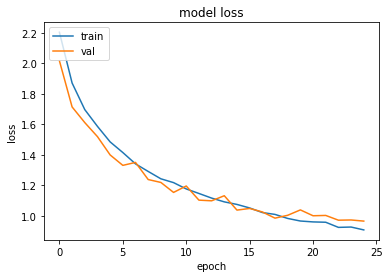

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
loss, acc = model.evaluate(X_test,y_test)
loss1, acc1 = model.evaluate(X_train,y_train)
print('Test loss:', loss,'   Test accuracy:', acc)
print('Train loss:', loss1,'   Train accuracy:',acc1)

104/104 [==============================] - 103s 985ms/step - loss: 0.7990 - accuracy: 0.7155
Test loss: 0.9648719429969788    Test accuracy: 0.6624561548233032
Train loss: 0.799018144607544    Train accuracy: 0.7154887318611145


## Resnet 50

In [ ]:
from keras.applications import ResNet152V2
# Instantiate a ResNet50 model with pre-trained weights
base_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

234545216/234545216 [==============================] - 1s 0us/step


In [ ]:
base_model.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                        

In [ ]:
# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)


# Add a logistic layer
predictions = Dense(12, activation='softmax')(x)
x = Dropout(0.5)(x)


# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.save('Resnet 50_0129.h5')
print(os.path.getsize("Resnet 50_0129.h5")/1048576, "MB")

232.0436248779297 MB


In [ ]:
# Train the model

history=model.fit(X_train, y_train , epochs=25, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/25
104/104 [==============================] - 158s 1s/step - loss: 1.4034 - accuracy: 0.5811 - val_loss: 0.8924 - val_accuracy: 0.6863
Epoch 2/25
104/104 [==============================] - 147s 1s/step - loss: 0.7280 - accuracy: 0.7408 - val_loss: 0.6000 - val_accuracy: 0.7846
Epoch 3/25
104/104 [==============================] - 145s 1s/step - loss: 0.5230 - accuracy: 0.8217 - val_loss: 0.6627 - val_accuracy: 0.7698
Epoch 4/25
104/104 [==============================] - 144s 1s/step - loss: 0.4432 - accuracy: 0.8508 - val_loss: 0.6768 - val_accuracy: 0.8014
Epoch 5/25
104/104 [==============================] - 144s 1s/step - loss: 0.3874 - accuracy: 0.8650 - val_loss: 0.6005 - val_accuracy: 0.8239
Epoch 6/25
104/104 [==============================] - 146s 1s/step - loss: 0.3140 - accuracy: 0.8884 - val_loss: 0.5688 - val_accuracy: 0.8267
Epoch 7/25
104/104 [==============================] - 144s 1s/step - loss: 0.2817 - accuracy: 0.9002 - val_loss: 0.5830 - val_accuracy: 0.8218

In [ ]:
model.save('Resnet 50_0129.h5')
print(os.path.getsize("Resnet 50_0129.h5")/1048576, "MB")

240.10370635986328 MB


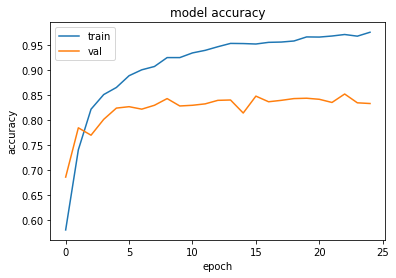

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


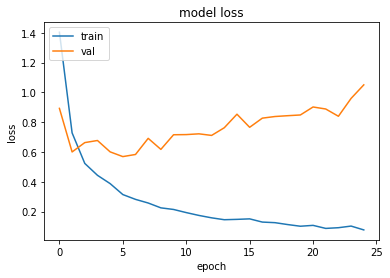

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [ ]:
loss, acc = model.evaluate(X_test,y_test)
loss1, acc1 = model.evaluate(X_train,y_train)
print('Test loss:', loss,'   Test accuracy:', acc)
print('Train loss:', loss1,'   Train accuracy:',acc1)


104/104 [==============================] - 100s 963ms/step - loss: 0.0083 - accuracy: 0.9979
Test loss: 1.0502790212631226    Test accuracy: 0.8329824805259705
Train loss: 0.008340130560100079    Train accuracy: 0.9978947639465332


## INCEPTION V3

In [ ]:
from keras.applications import InceptionV3
# Instantiate a InceptionV3 model with pre-trained weights
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False


87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [ ]:
# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)


# Add a logistic layer
predictions = Dense(12, activation='softmax')(x)
x = Dropout(0.5)(x)


# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)


In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                           

In [ ]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.save('INCEPTION_other_0129.h5')


print(os.path.getsize("INCEPTION_other_0129.h5")/1048576, "MB")


92.0603256225586 MB


In [ ]:
# Train the model

history=model.fit(X_train, y_train , epochs=25, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/25
104/104 [==============================] - 38s 322ms/step - loss: 2.1220 - accuracy: 0.4638 - val_loss: 0.9075 - val_accuracy: 0.6996
Epoch 2/25
104/104 [==============================] - 31s 303ms/step - loss: 1.0432 - accuracy: 0.6526 - val_loss: 0.9224 - val_accuracy: 0.6856
Epoch 3/25
104/104 [==============================] - 32s 306ms/step - loss: 0.8564 - accuracy: 0.7065 - val_loss: 0.7571 - val_accuracy: 0.7389
Epoch 4/25
104/104 [==============================] - 32s 307ms/step - loss: 0.6999 - accuracy: 0.7600 - val_loss: 0.9423 - val_accuracy: 0.7074
Epoch 5/25
104/104 [==============================] - 32s 307ms/step - loss: 0.6445 - accuracy: 0.7789 - val_loss: 0.8032 - val_accuracy: 0.7572
Epoch 6/25
104/104 [==============================] - 32s 307ms/step - loss: 0.5791 - accuracy: 0.7982 - val_loss: 0.8768 - val_accuracy: 0.7263
Epoch 7/25
104/104 [==============================] - 32s 306ms/step - loss: 0.5246 - accuracy: 0.8174 - val_loss: 0.8134 - val_ac

In [ ]:
model.save('INCEPTION_other_0129.h5')


print(os.path.getsize("INCEPTION_other_0129.h5")/1048576, "MB")



100.1203384399414 MB


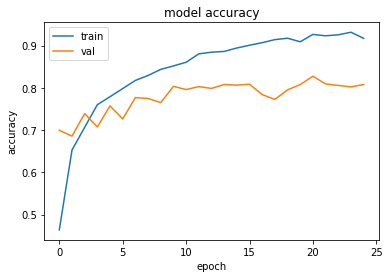

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


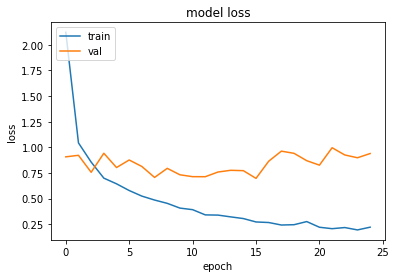

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()



In [ ]:
loss, acc = model.evaluate(X_test,y_test)
loss1, acc1 = model.evaluate(X_train,y_train)
print('Test loss:', loss,'   Test accuracy:', acc)
print('Train loss:', loss1,'   Train accuracy:',acc1)


104/104 [==============================] - 23s 217ms/step - loss: 0.0618 - accuracy: 0.9762
Test loss: 0.939697802066803    Test accuracy: 0.8077192902565002
Train loss: 0.06177806481719017    Train accuracy: 0.9762405753135681


## XCEPTION

In [ ]:
from keras.applications import Xception
# Instantiate a Xception model with pre-trained weights
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False


83683744/83683744 [==============================] - 1s 0us/step


In [ ]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [ ]:
# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)


# Add a logistic layer
predictions = Dense(12, activation='softmax')(x)
x = Dropout(0.5)(x)


# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

In [ ]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.save('XCEPTION_other_0129.h5')


print(os.path.getsize("XCEPTION_other_0129.h5")/1048576, "MB")


88.02407836914062 MB


In [ ]:
# Train the model

history=model.fit(X_train, y_train , epochs=25, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/25
104/104 [==============================] - 76s 711ms/step - loss: 1.3901 - accuracy: 0.5435 - val_loss: 0.9595 - val_accuracy: 0.6709
Epoch 2/25
104/104 [==============================] - 70s 674ms/step - loss: 0.8462 - accuracy: 0.6989 - val_loss: 0.8957 - val_accuracy: 0.7081
Epoch 3/25
104/104 [==============================] - 70s 676ms/step - loss: 0.6744 - accuracy: 0.7711 - val_loss: 0.7279 - val_accuracy: 0.7586
Epoch 4/25
104/104 [==============================] - 69s 669ms/step - loss: 0.5556 - accuracy: 0.8066 - val_loss: 0.7465 - val_accuracy: 0.7712
Epoch 5/25
104/104 [==============================] - 70s 677ms/step - loss: 0.4848 - accuracy: 0.8310 - val_loss: 0.6667 - val_accuracy: 0.7761
Epoch 6/25
104/104 [==============================] - 70s 675ms/step - loss: 0.4267 - accuracy: 0.8541 - val_loss: 0.8167 - val_accuracy: 0.7439
Epoch 7/25
104/104 [==============================] - 71s 685ms/step - loss: 0.3634 - accuracy: 0.8722 - val_loss: 0.7459 - val_ac

In [ ]:
model.save('XCEPTION_other_0129.h5')


print(os.path.getsize("XCEPTION_other_0129.h5")/1048576, "MB")



96.0842514038086 MB


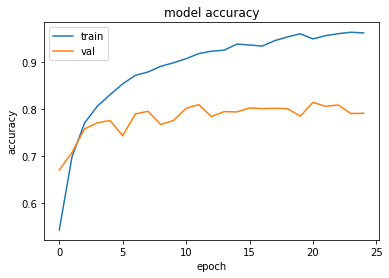

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


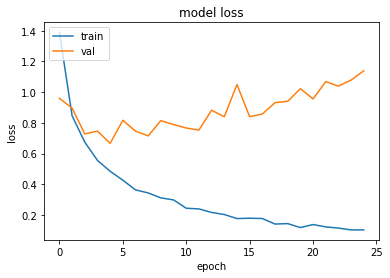

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()



In [ ]:
loss, acc = model.evaluate(X_test,y_test)
loss1, acc1 = model.evaluate(X_train,y_train)
print('Test loss:', loss,'   Test accuracy:', acc)
print('Train loss:', loss1,'   Train accuracy:',acc1)


104/104 [==============================] - 51s 495ms/step - loss: 0.0247 - accuracy: 0.9943
Test loss: 1.1388620138168335    Test accuracy: 0.7915789484977722
Train loss: 0.024729125201702118    Train accuracy: 0.9942857027053833


## **DenseNet121**

In [ ]:
from keras.applications import DenseNet121
# Instantiate a DenseNet121 model with pre-trained weights
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False


29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_5[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

In [ ]:
# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)


# Add a logistic layer
predictions = Dense(12, activation='softmax')(x)
x = Dropout(0.5)(x)


# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)


In [ ]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_5[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

In [ ]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.save('DenseNet121_other_0129.h5')


print(os.path.getsize("DenseNet121_other_0129.h5")/1048576, "MB")


32.02588653564453 MB


In [ ]:
# Train the model

history=model.fit(X_train, y_train , epochs=25, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/25
104/104 [==============================] - 81s 732ms/step - loss: 1.5876 - accuracy: 0.4875 - val_loss: 0.9072 - val_accuracy: 0.7088
Epoch 2/25
104/104 [==============================] - 77s 743ms/step - loss: 0.9268 - accuracy: 0.6839 - val_loss: 0.6439 - val_accuracy: 0.7923
Epoch 3/25
104/104 [==============================] - 76s 732ms/step - loss: 0.7390 - accuracy: 0.7411 - val_loss: 0.8537 - val_accuracy: 0.6961
Epoch 4/25
104/104 [==============================] - 78s 750ms/step - loss: 0.6280 - accuracy: 0.7762 - val_loss: 0.6295 - val_accuracy: 0.7916
Epoch 5/25
104/104 [==============================] - 75s 725ms/step - loss: 0.5384 - accuracy: 0.8096 - val_loss: 0.5572 - val_accuracy: 0.8204
Epoch 6/25
104/104 [==============================] - 74s 717ms/step - loss: 0.5166 - accuracy: 0.8147 - val_loss: 0.6441 - val_accuracy: 0.7916
Epoch 7/25
104/104 [==============================] - 74s 718ms/step - loss: 0.4657 - accuracy: 0.8394 - val_loss: 0.5688 - val_ac

In [ ]:
model.save('DenseNet121_other_0129.h5')


print(os.path.getsize("DenseNet121_other_0129.h5")/1048576, "MB")



36.086036682128906 MB


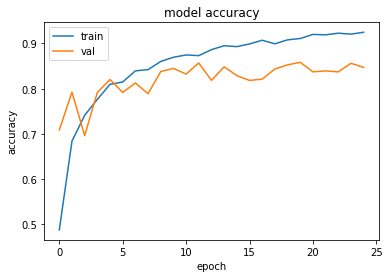

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


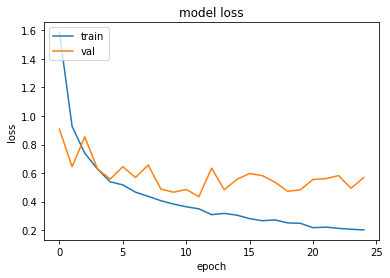

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()



In [ ]:
loss, acc = model.evaluate(X_test,y_test)
loss1, acc1 = model.evaluate(X_train,y_train)
print('Test loss:', loss,'   Test accuracy:', acc)
print('Train loss:', loss1,'   Train accuracy:',acc1)


104/104 [==============================] - 50s 477ms/step - loss: 0.1114 - accuracy: 0.9612
Test loss: 0.5685667395591736    Test accuracy: 0.8470175266265869
Train loss: 0.11140044033527374    Train accuracy: 0.9612029790878296


### MobileNetV2

In [ ]:
from keras.applications import MobileNetV2
# Instantiate a DenseNet121 model with pre-trained weights
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False


9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [ ]:
# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)


# Add a logistic layer
predictions = Dense(12, activation='softmax')(x)
x = Dropout(0.5)(x)


# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)


In [ ]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [ ]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.save('MobileNetV2_0129.h5')


print(os.path.getsize("MobileNetV2_0129.h5")/1048576, "MB")


14.125572204589844 MB


In [ ]:
# Train the model

history=model.fit(X_train, y_train , epochs=25, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/25
104/104 [==============================] - 27s 236ms/step - loss: 1.7434 - accuracy: 0.5104 - val_loss: 1.1363 - val_accuracy: 0.6133
Epoch 2/25
104/104 [==============================] - 23s 219ms/step - loss: 0.8696 - accuracy: 0.7035 - val_loss: 0.6825 - val_accuracy: 0.7635
Epoch 3/25
104/104 [==============================] - 23s 221ms/step - loss: 0.7074 - accuracy: 0.7555 - val_loss: 0.6426 - val_accuracy: 0.7761
Epoch 4/25
104/104 [==============================] - 23s 222ms/step - loss: 0.6117 - accuracy: 0.7910 - val_loss: 0.6277 - val_accuracy: 0.8175
Epoch 5/25
104/104 [==============================] - 23s 220ms/step - loss: 0.5506 - accuracy: 0.8102 - val_loss: 0.5340 - val_accuracy: 0.8049
Epoch 6/25
104/104 [==============================] - 23s 217ms/step - loss: 0.4852 - accuracy: 0.8301 - val_loss: 0.5955 - val_accuracy: 0.8126
Epoch 7/25
104/104 [==============================] - 23s 218ms/step - loss: 0.4477 - accuracy: 0.8400 - val_loss: 0.5869 - val_ac

In [ ]:
model.save('DenseNet121_other_0129.h5')


print(os.path.getsize("DenseNet121_other_0129.h5")/1048576, "MB")



19.185760498046875 MB


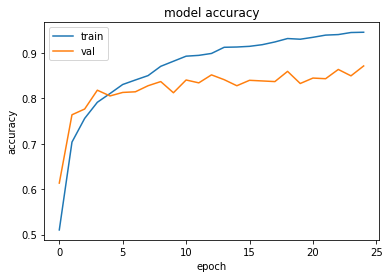

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


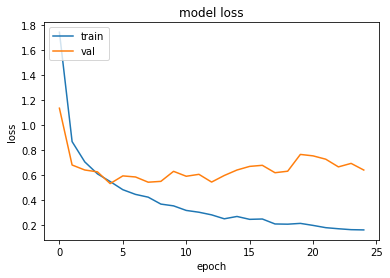

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()



In [ ]:
loss, acc = model.evaluate(X_test,y_test)
loss1, acc1 = model.evaluate(X_train,y_train)
print('Test loss:', loss,'   Test accuracy:', acc)
print('Train loss:', loss1,'   Train accuracy:',acc1)


104/104 [==============================] - 15s 143ms/step - loss: 0.0460 - accuracy: 0.9844
Test loss: 0.6422231793403625    Test accuracy: 0.870877206325531
Train loss: 0.046012163162231445    Train accuracy: 0.9843608736991882


## **Predict train model**

In [ ]:
predictions = model.predict(X_test)

45/45 [==============================] - 8s 168ms/step


In [ ]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = np.argmax(true_label[i]), img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% \n({})".format(np.array(df.Name)[predicted_label],
                                100*np.max(predictions_array),
                                np.array(df.Name)[true_label]),
                                color=color)

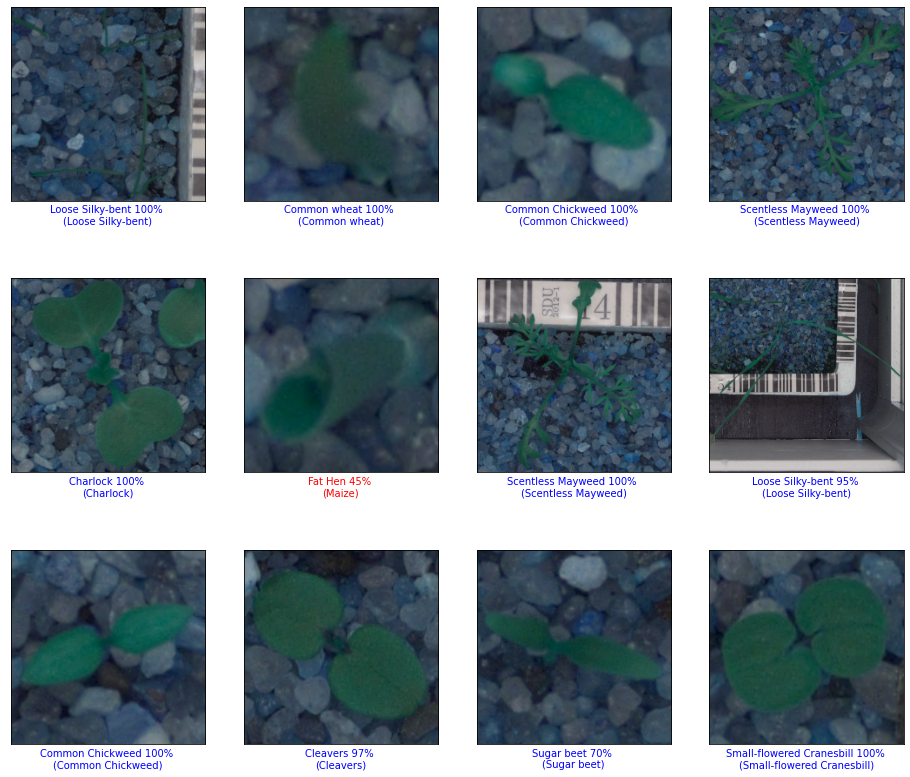

In [ ]:
fig=plt.figure(figsize=(16, 20))
rows, cols = 3,4
for i in range(0, cols*rows):
    fig.add_subplot(rows, cols, i+1)
    plot_image(i, predictions[i], y_test, X_test)
    plt.subplots_adjust(hspace=-0.5)
plt.show()